# Compare Track Profiles

**Import necessary packages**

In [1]:
import shapely as sp
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import ICESat2GroundingLineMigration.IceSatHDF5Unpacker as unpack
import src.TrackProfileUtil as util
pd.options.mode.chained_assignment = None

### Import data file & gline polygon

`data_path` - Path to exported data file <br>
`study_area_path` - Path to study area mask <br>
`proj4_crs` - Proj4 string of the crs

In [2]:
data_path = "RAW-Bungen2021-01-maybe.json"
study_area_path = "Bounds/bungen.gpkg"
proj4_crs = "+proj=stere +lat_0=-90 +lat_ts=-71 +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"

data = gpd.read_file(f"Saves/{data_path}")
study_area = gpd.read_file(study_area_path)
study_area = study_area.to_crs(proj4_crs)

In [3]:
bounds = study_area["geometry"].total_bounds
xlim, ylim = (bounds[0], bounds[2]), (bounds[1], bounds[3])

## Turn GLine to dataframe
The grounding line is already in a dataframe, however it needs to be reformatted. This is because it is one large polygon. <br>
*Additionally* to speed up processing we only want the part of the grounding line within the study area.

To this we deconstruct the dataframe, and then rebuild it after performing some operations.

In [4]:
basemap = unpack.Basemap("BackgroundData/GroundedIce.gpkg")
gline_xy = util.gline_to_df(basemap.basemap_gpd, study_area)

## Create general processing function for each granule

This is the exact same process as in `TrackAnalysis.ipynb`. <br>
It goes as follows: Extract beam from gdf containing all data, compute along track distance, check along track distance, turn gline & track into linestrings, find intersection between linestrings, find distance at intersection, convert units, set dist = 0 to be at the gline, apply lowpass filter.

In [15]:
def process_and_extract(data, rgt, name, gline_xy=gline_xy, verbose=True):
    
    # extract data
    single_beam = util.extract_data(data, rgt, name)
    
    # compute along track distance
    single_beam = util.compute_along_track_dist(single_beam, verbose)
    
    # Hunt for intersect w/ gline
    single_beam, gline = util.find_gline_int(single_beam, gline_xy, verbose)
    
    # compute distance to the grounding line
    single_beam = util.find_gline_dist(single_beam, gline)
    
    order = 5
    cutoff = 0.05
    single_beam[f"slope-filt"] = util.apply_butter(single_beam["slope"], order, cutoff)
    
    return single_beam

#
# Execute processing on multiple tracks and compare

`rgt_list` - Region ground tracks of interest <br>
`track_list` - Track names of interest <br>
`beam_dfs` - Storage for dataframes for each beam

In [16]:
print(f"RGTs: \n{np.unique(np.array(data['rgt']))}")

RGTs: 
[  19.   34.   56.   95.  132.  156.  178.  193.  217.  278.  315.  339.
  376.  400.  437.  461.  498.  620.  635.  659.  696.  720.  757.  781.
  842.  879.  903.  940. 1016. 1040. 1062. 1077. 1101. 1162. 1223. 1321.
 1345.]


In [17]:
rgt_list = [1101]
track_list = ["gt3r", "gt2r", "gt1r"]
beam_dfs = []

### Perform processing on all the rgt's and tracks listed.
This means that the amount of output df's ` = len(rgt_list) * len(track_list)`

In [18]:
for rgt in rgt_list:
    for track in track_list:
        single_beam = process_and_extract(data, rgt, track, verbose=False)
        beam_dfs.append(single_beam)

In [19]:
colors = ["red", "pink", "green", "lightgreen", "blue", "lightblue"]

### Visualize
To properly visualize the color gradient must be identical for all tracks. So we need to find max and min slope for all tracks.

In [20]:
maximum, minimum = util.find_max_min(beam_dfs, "gline_dist")
print(f"Max dist: {maximum}  Min dist: {minimum}")

Max dist: 19.800325331318362  Min dist: -27.074497133912637


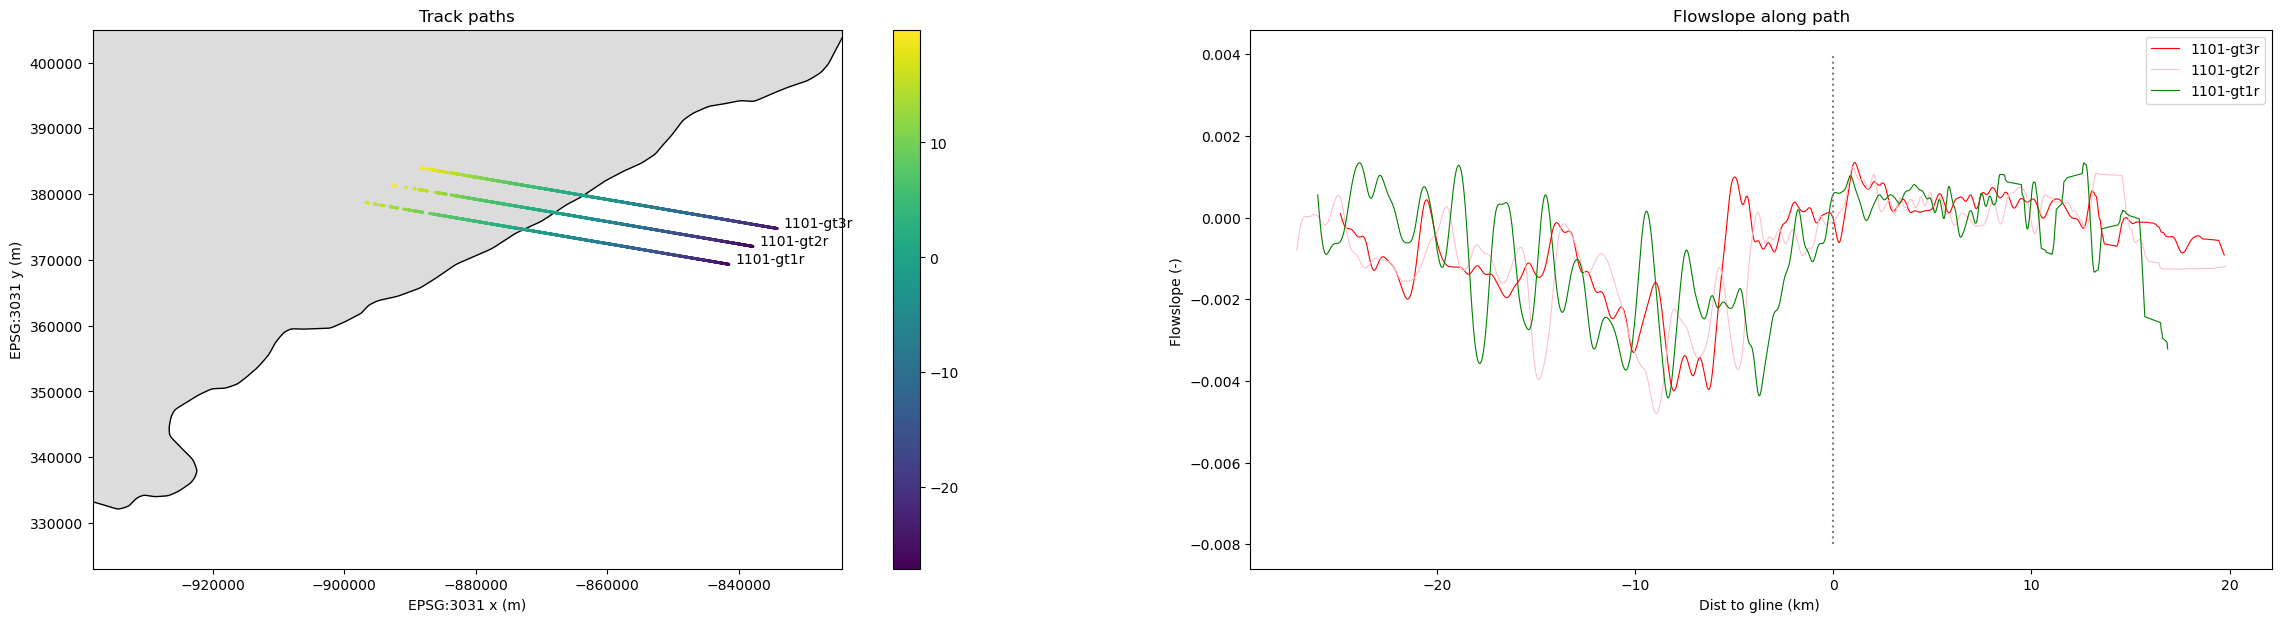

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(29,7))

ax[0].set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax[0], color="white", edgecolor="black")

i = 0
for single_beam in beam_dfs:
    single_beam["index"] = single_beam.index
    if i == 0:
        single_beam.plot(ax=ax[0], column="gline_dist", vmax = maximum, vmin = minimum, aspect = 1, markersize = 1, legend=True)
    else:
        single_beam.plot(ax=ax[0], column="gline_dist", vmax = maximum, vmin = minimum, aspect = 1, markersize = 1, legend=False)
    px, py = single_beam["geometry"].iloc[0].xy
    x, y = px[0], py[0]
    rgt = int(single_beam["rgt"].iloc[0])
    name = single_beam["name"].iloc[0]
    ax[0].text(x + 1000, y + 100, f"{rgt}-{name}")
    ax[1].plot(single_beam["gline_dist"],single_beam["slope-filt"], 
               c=colors[i], label = f"{rgt}-{name}", linewidth= 0.8)
    i += 1
    
ax[0].set_ylim(ylim[0], ylim[1])
ax[0].set_xlim(xlim[0], xlim[1])
ax[0].set_xlabel("EPSG:3031 x (m)")
ax[0].set_ylabel("EPSG:3031 y (m)")
ax[0].set_title("Track paths")

ax[1].vlines(0, ymin=-0.008, ymax=0.004, linestyles = "dotted", color="gray")
ax[1].set_title("Flowslope along path")
ax[1].set_xlabel("Dist to gline (km) ")
ax[1].set_ylabel("Flowslope (-) ")
ax[1].legend()

plt.show()

## Compute & visualize derivatives

In [22]:
for single_beam in beam_dfs:
    single_beam = util.deriv_on_gpd(single_beam)

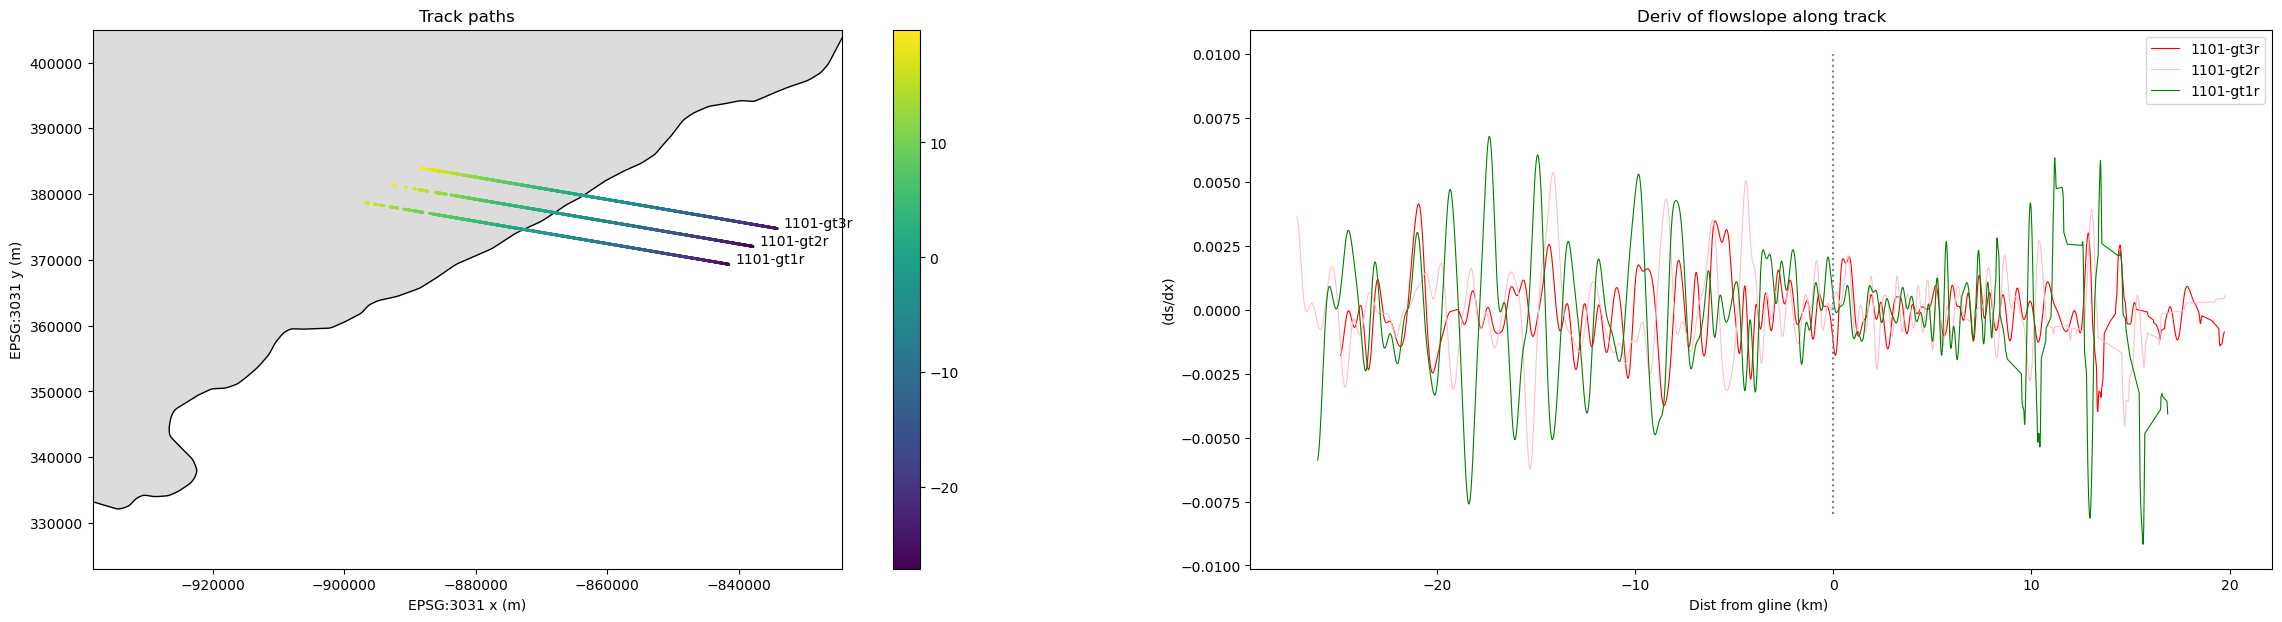

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(29,7))

ax[0].set_facecolor("gainsboro")
basemap.basemap_gpd.plot(ax=ax[0], color="white", edgecolor="black")

i = 0
for single_beam in beam_dfs:
    single_beam["index"] = single_beam.index
    if i == 0:
        single_beam.plot(ax=ax[0], column="gline_dist", vmax = maximum, vmin = minimum, aspect = 1, markersize = 1, legend=True)
    else:
        single_beam.plot(ax=ax[0], column="gline_dist", vmax = maximum, vmin = minimum, aspect = 1, markersize = 1, legend=False)
    px, py = single_beam["geometry"].iloc[0].xy
    x, y = px[0], py[0]
    rgt = int(single_beam["rgt"].iloc[0])
    name = single_beam["name"].iloc[0]
    ax[0].text(x + 1000, y + 100, f"{rgt}-{name}")
    ax[1].plot(single_beam["gline_dist"],single_beam["slope_deriv_1-filt"], 
               c=colors[i], label = f"{rgt}-{name}", linewidth= 0.8)
    i += 1
    
ax[0].set_ylim(ylim[0], ylim[1])
ax[0].set_xlim(xlim[0], xlim[1])
ax[0].set_xlabel("EPSG:3031 x (m)")
ax[0].set_ylabel("EPSG:3031 y (m)")
ax[0].set_title("Track paths")

ax[1].vlines(0, ymin=-0.008, ymax=0.01, linestyles = "dotted", color="gray")
ax[1].set_title("Deriv of flowslope along track")
ax[1].set_xlabel("Dist from gline (km) ")
ax[1].set_ylabel("(ds/dx)")
ax[1].legend()

plt.show()